### imports 

In [1]:
import os
from os import path
import configparser
from github import Github
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timezone
import requests
from requests.adapters import HTTPAdapter, Retry

In [10]:
import githubanalysis.processing.repo_name_clean as name_clean
import githubanalysis.processing.get_repo_connection as ghconnect
import githubanalysis.processing.setup_github_auth as ghauth
import githubanalysis.processing.get_all_pages_issues as getallissues
import githubanalysis.processing.get_issue_assignees as get_assignee
import githubanalysis.analysis.calc_days_since_repo_creation as dayssince
import githubanalysis.processing.summarise_repo_stats
from githubanalysis.processing.summarise_repo_stats import RepoStatsSummariser
import utilities.get_default_logger as loggit
import utilities.chunker as chunker

### access token 

In [3]:
# set up github access token with github package: 

config = configparser.ConfigParser()
config.read('../config.cfg')
config.sections()

access_token = config['ACCESS']['token']
g = Github(access_token) 

gh_token = ghauth.setup_github_auth(config_path='../../githubanalysis/config.cfg')
headers = {f"Authorization: Bearer {gh_token}"}

In [4]:
#repo_name = 'MotionbyLearning/stm' # 61
repo_name = 'JeschkeLab/DeerLab'

import githubanalysis.processing.get_all_pages_issues
from githubanalysis.processing.get_all_pages_issues import IssueGetter

logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/get_all_pages_issues_NOTEBOOK_logs.txt')  
issues_getter = IssueGetter(logger)

iss_df = issues_getter.get_all_pages_issues(repo_name=repo_name, config_path='../../githubanalysis/config.cfg', out_filename='all-issues', write_out_location='../../data/')

INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 1 of 5.
INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 2 of 5.
INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 3 of 5.
INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 4 of 5.
INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 5 of 5.


In [5]:
iss_df.state.value_counts().open

5

In [6]:
print(f"issue state counts: {iss_df.state.value_counts()}")

issue state counts: closed    450
open        5
Name: state, dtype: int64


In [12]:
iss_devs = get_assignee.get_issue_assignees(iss_df)

Dataframe has original dimensions: (455, 31).
Dataframe has been updated with 'assigned_devs' info and now has dimensions: (455, 31).


In [34]:
iss_devs.assigned_devs.value_counts()

[]                     303
[luisfabib]            114
[HKaras]                21
[stestoll]              16
[HKaras, luisfabib]      1
Name: assigned_devs, dtype: int64

In [14]:
# reshape dataset to make taller on 'assigned_devs' column (ie 1x row:[dev1, dev2]; -> 2x rows: dev1; dev2
exploded_devs = iss_devs.apply(pd.Series).explode(column='assigned_devs', ignore_index=True)

In [17]:
exploded_devs.assigned_devs.value_counts(normalize=True, dropna=False)

NaN          0.664474
luisfabib    0.252193
HKaras       0.048246
stestoll     0.035088
Name: assigned_devs, dtype: float64

NaN          303
luisfabib    115
HKaras        22
stestoll      16
Name: assigned_devs, dtype: int64


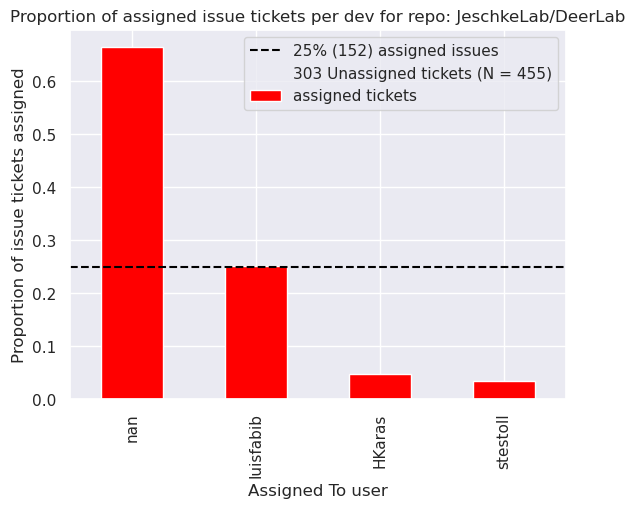

In [53]:
# calculate 25% of assigned tickets
all_tix = len(iss_devs.index)
total_assigned = len(iss_devs[[bool(x) for x in iss_devs.assigned_devs]])
#non_assigned = all_tix - total_assigned
non_assigned_text = f'{all_tix - total_assigned} Unassigned tickets (N = {all_tix})'

print(exploded_devs['assigned_devs'].value_counts(dropna=False))  # print per-dev assignment counts

# do actual plotting:
exploded_devs['assigned_devs'].value_counts(normalize=True, dropna=False).plot.bar(column='assigned_devs', color='red', label='assigned tickets')

plt.xlabel("Assigned To user")
plt.ylabel("Proportion of issue tickets assigned")
plt.title(f"Proportion of assigned issue tickets per dev for repo: {repo_name}")
plt.axhline(y=(0.25), linestyle='--', color='black', label=f'25% ({total_assigned}) assigned issues')  # plot line at 25% of all closed assigned tickets
plt.plot([], [], ' ', label=non_assigned_text)  # Create empty plot with blank marker containing the extra label
plt.legend(loc='upper right')

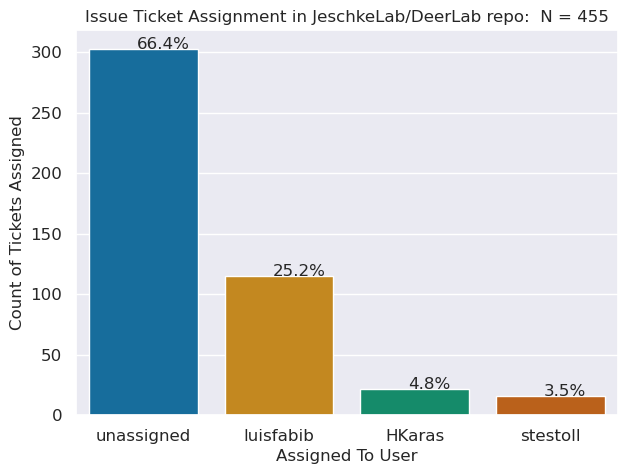

In [84]:
# plot issue ticket assignment proportions amongst devs for 1 repo

def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()
    # method for plotting percentages onto seaborn plot without hue via https://stackoverflow.com/a/62076347

# calculate 25% of assigned tickets
all_tix = len(iss_devs.index)
#total_assigned = len(iss_devs[[bool(x) for x in iss_devs.assigned_devs]]) # used by axhline label if used

    
# deal with NaNs: 
exploded_devs['assigned_devs'] = exploded_devs['assigned_devs'].fillna('unassigned')   # via https://stackoverflow.com/a/46415931

plt.figure(figsize=(7,5))
ax=sns.countplot(
    x='assigned_devs', 
    data=exploded_devs, 
    order = exploded_devs['assigned_devs'].value_counts(dropna=False).index  # order the bars; via https://stackoverflow.com/a/46624802
)
plt.xticks(size=12)
plt.xlabel('Assigned To User', size=12)
plt.yticks(size=12)
plt.ylabel('Count of Tickets Assigned', size=12)
#plt.axhline(y=(all_tix*0.10), linestyle='--', color='black', label=f'25% ({total_assigned}) assigned issues')  # plot line at 10% of all assigned tickets
plt.title(f"Issue Ticket Assignment in {repo_name} repo:  N = {all_tix}")


without_hue(ax, exploded_devs.assigned_devs)

<Axes: xlabel='day', ylabel='proportion'>

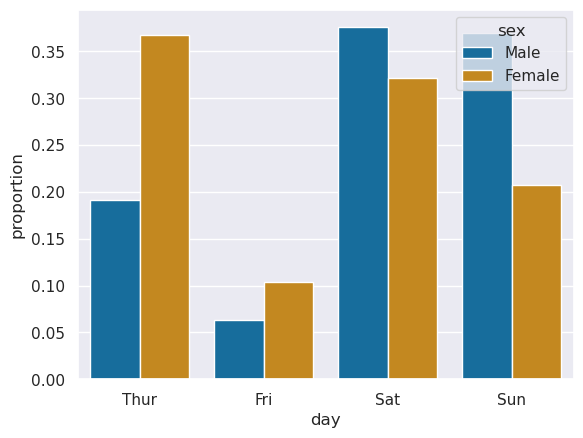

In [54]:
import pandas as pd
import seaborn as sns

df = sns.load_dataset("tips")
x, y, hue = "day", "proportion", "sex"
hue_order = ["Male", "Female"]

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

### Load 1 repo content via get_repo_connection() 

In [ ]:
# repo_con = ghconnect.get_repo_connection(repo_name='harnesscloud/irm-nova', config_path='../../githubanalysis/config.cfg')
# repo_con = repo_con.json()
# print(repo_con)

### Load 1 repo content via s.get() 

In [ ]:
# gh_token = ghauth.setup_github_auth(config_path='../../githubanalysis/config.cfg')
# headers = {'Authorization': 'token ' + gh_token}

# s = requests.Session()
# retries = Retry(total=10, connect=5, read=3, backoff_factor=1.5, status_forcelist=[202, 502, 503, 504])
# s.mount('https://', HTTPAdapter(max_retries=retries))

### Load repo stats file

In [86]:
total_stats = pd.read_csv("../../data/gh_stats_2024-02-14-eidf.csv", header=0, nrows=250)
print(total_stats.head)

<bound method NDFrame.head of                                     repo_name  initial_HTTP_code  \
0         leonmhartman/Gnotobiotic_E.diaphana                200   
1                ProyectoAether/Aether-Portal                200   
2                        MotionbyLearning/stm                200   
3     nicolasfara/reconfiguration-experiments                200   
4              ashleefv/CFDparticleLungMucosa                200   
..                                        ...                ...   
245                        YijinHuang/BBR-Net                200   
246          FPAL-Stanford-University/PadeOps                200   
247                              dyu14/ERADAT                200   
248                 TimSoethout/cbc-artifacts                200   
249  zidianjun/metallicity-correlation-CALIFA                200   

    issues_enabled repo_is_fork  devs  total_commits_last_year has_PRs  \
0             True        False   1.0                      0.0   False   
1    

In [87]:
len(total_stats.index) # number of records (so far)

250

In [89]:
total_stats['initial_HTTP_code'].value_counts()

200    247
404      3
Name: initial_HTTP_code, dtype: int64

## Subset: only non-404 repos:

In [90]:
total_stats_200s = total_stats[total_stats['initial_HTTP_code'] == 200]

#total_stats_200s[['devs', 'repo_age_days', 'total_commits_last_year']].describe()

In [91]:
total_stats_200s['has_issues'] = np.where((total_stats_200s['open_tickets'] > 1) | (total_stats_200s['closed_tickets'] > 1), True, False)
total_stats_200s['all_tickets'] = (total_stats_200s['open_tickets'] + total_stats_200s['closed_tickets'])

#print(total_stats_200s)

/tmp/ipykernel_20577/447263214.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_stats_200s['has_issues'] = np.where((total_stats_200s['open_tickets'] > 1) | (total_stats_200s['closed_tickets'] > 1), True, False)
/tmp/ipykernel_20577/447263214.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_stats_200s['all_tickets'] = (total_stats_200s['open_tickets'] + total_stats_200s['closed_tickets'])


In [92]:
total_stats_200s[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].mean()

devs                 4.493927
repo_age_days     1414.983806
all_tickets         81.534413
open_tickets         1.680162
closed_tickets      79.854251
dtype: float64

In [93]:
total_stats_200s[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].max()

devs                252.0
repo_age_days      4163.0
all_tickets       16936.0
open_tickets         47.0
closed_tickets    16923.0
dtype: float64

In [94]:
# Find the outlier: 
# https://github.com/swsoyee/2019-ncov-japan/issues 
# "Interactive dashboard for real-time recording of COVID-19 outbreak in Japan"
total_stats_200s[total_stats_200s['closed_tickets'] > 16900]

,repo_name,initial_HTTP_code,issues_enabled,repo_is_fork,devs,total_commits_last_year,has_PRs,last_PR_update,open_tickets,closed_tickets,repo_age_days,repo_license,repo_visibility,repo_language,has_issues,all_tickets
93,swsoyee/2019-ncov-japan,200,True,False,12.0,0.0,True,2022-12-17 06:29:43+00:00,13.0,16923.0,1476.0,MIT,True,"dict_keys(['R', 'JavaScript', 'HTML'])",True,16936.0


In [95]:
tmp = total_stats_200s.drop([93])
tmp[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].max()

devs               252.0
repo_age_days     4163.0
all_tickets        441.0
open_tickets        47.0
closed_tickets     406.0
dtype: float64

## remove closed_tickets outlier  

In [96]:
total_stats_200s = total_stats_200s.drop([93])

In [97]:
total_stats_200s[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].mean()

devs                 4.463415
repo_age_days     1414.735772
all_tickets         13.020325
open_tickets         1.634146
closed_tickets      11.386179
dtype: float64

Starting number: 250 records.

Data excluded:  
 - 404 repos (may have been made private, or deleted?)  (removes 3 records) 
 - huge outlier of closed_tickets (removes 1 record)   
 
Possibly worth excluding further: 
 - repos with < 50 devs (removes 2 records from the set) 
 - repos which are a fork? (removes 11 records) 
 

Key interesting points: 

 - issue-using repos:  
   - are older on average  
   - are more active (higher commits in last year)  
   - have larger numbers of devs in the repo  
 
 - solo-dev repos are SUPER COMMON; repos with more than 10 devs are much less common.    
 
 - there's a difference in behaviour between repos using issues vs not using issues in YOUNG repos (~1st year; < 500 days) in their commit activity in the last year. Repos not using issues tend to have lower numbers of commits in their first year; there are fewer repos using issues in the first year, but all have fairly high commits in their first year. This isn't explained by forked-ness.  
 
 - Repos up to 5 years are the most common. Again, seeing the split between issue use here... Age distribution is fairly even amongst issue-users, but NOT non-issues-users.
 

Worth investigating:  
 - Zenodo record creation dates vs github repo ages  
 - actual commits data (not just number of commits in last year)  
 - binning devs numbers: 1, 2-5, 6+ and plotting out behaviours with   
 
 

In [98]:
repo_name = 'MotionbyLearning/stm' # 61
#repo_name = 'nicolasfara/reconfiguration-experiments'

gh_token = ghauth.setup_github_auth(config_path='../../githubanalysis/config.cfg')
headers = {'Authorization': 'token ' + gh_token}

s = requests.Session()
retries = Retry(total=10, connect=5, read=3, backoff_factor=1.5, status_forcelist=[202, 502, 503, 504])
s.mount('https://', HTTPAdapter(max_retries=retries))

In [ ]:
state='all'
issues_url = f"https://api.github.com/repos/{repo_name}/issues?state={state}&per_page=100&pulls=false"
#print(issues_url)

api_response = s.get(url=issues_url, headers=headers)

In [ ]:
#dir(api_response)

In [ ]:
print(api_response.links)

In [ ]:
issue_links = api_response.links

if 'last' in issue_links:
    issue_links_last = issue_links['last']['url'].split("&page=")[1]
    pages_issues = int(issue_links_last)

    print(pages_issues)

In [ ]:
#df_js = pd.read_json('https://api.github.com/repositories/693656185/issues?state=all&per_page=100&page=2&pulls=false')

In [ ]:
#print(df_js)

In [ ]:
# r = range(1,5)
# for i in r:
#     print(i)

In [ ]:
pg_range = range(1, (pages_issues+1))
all_issues = pd.DataFrame()
store_pgs = pd.DataFrame()

print(pg_range)


for i in pg_range: 
    print(i)
    store_pgs = pd.read_json(path_or_buf=f"https://api.github.com/repos/{repo_name}/issues?state={state}&per_page=100&page={i}&pulls=false")
    all_issues = pd.concat([all_issues, store_pgs], )

print(len(all_issues.index))
print(len(store_pgs.index))


In [ ]:
all_issues

In [ ]:
print(iss_df)

In [ ]:
iss_df.dtypes

In [ ]:
iss_df.state

### Key stats differences between issues-users and non-issue-users

In [ ]:
total_stats_200s.groupby('has_issues').mean(numeric_only=True)

## Distribution of repo ages: bar per year of age  (split by issue-use)

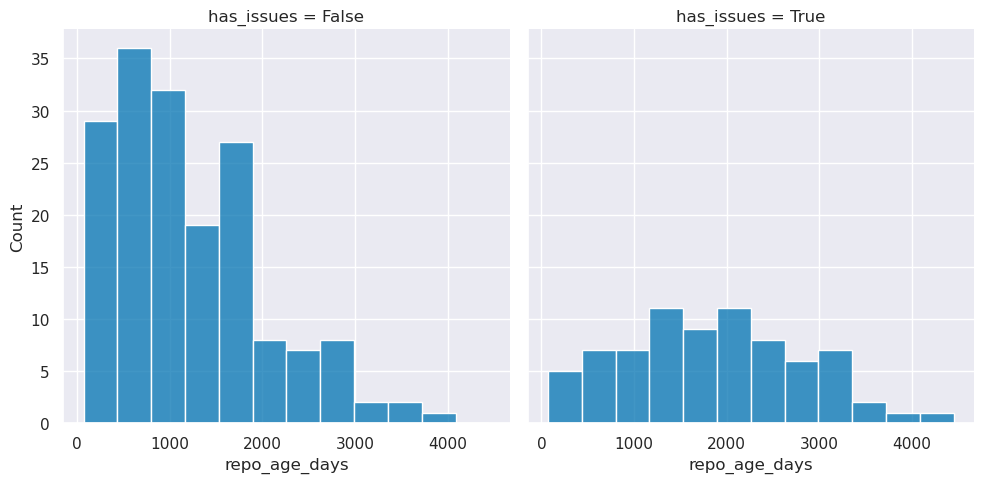

In [99]:
sns.displot(data=total_stats_200s, x='repo_age_days', binwidth=365, col='has_issues')

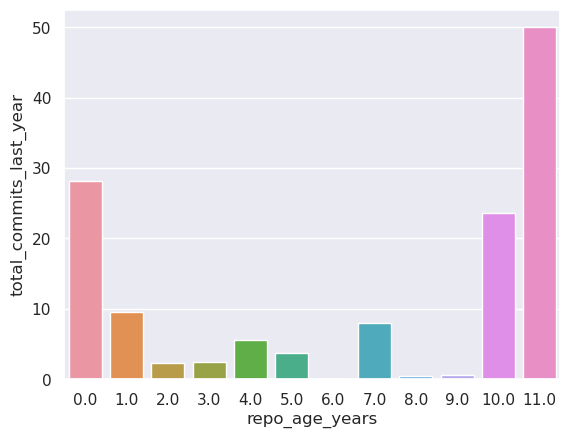

In [123]:
#sns.displot(data=total_stats_200s, x='repo_age_days', y='total_commits_last_year', kind='hist')

# Plot repo age (x) vs total commits last year (y) as bar chart of binned years and activity on y. 
# Maybe side-by-side the issues/non-issues/both as bars TODO: explain

sns.set_theme() 
sns.set_palette('colorblind')

# add new column to data that's the repos age in years to bin by
total_stats_200s['repo_age_years'] = (total_stats_200s['repo_age_days'] // 365 )  # use integer division, not float division (10 // 3 = 3)

#print(total_stats_200s['repo_age_years'])

ax = sns.barplot(data=total_stats_200s, x='repo_age_years', y='total_commits_last_year', estimator='mean', errorbar=None)
#ax.bar_label(ax.containers[0].round(2), fontsize=10);

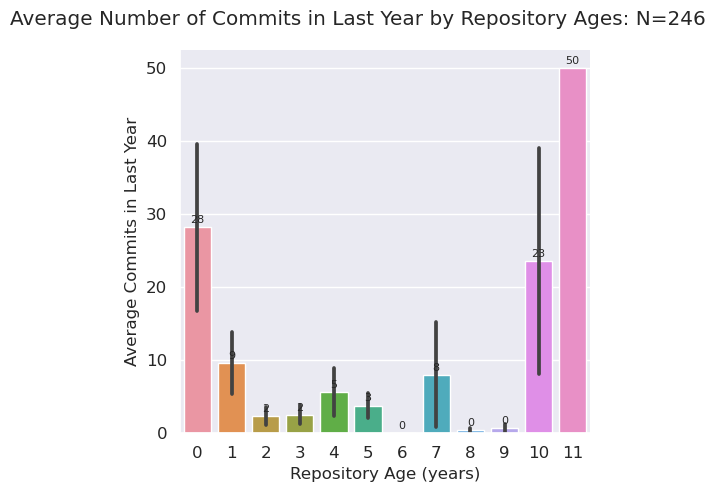

In [160]:
#sns.displot(data=total_stats_200s, x='repo_age_days', y='total_commits_last_year', kind='hist')

# Plot repo age (x) vs total commits last year (y) as bar chart of binned years and activity on y. 
# Maybe side-by-side the issues/non-issues/both as bars TODO: explain

sns.set_theme() 
sns.set_palette('colorblind')

# add new column to data that's the repos age in years to bin by
total_stats_200s['repo_age_years'] = (total_stats_200s['repo_age_days'] // 365 )  # use integer division, not float division (10 // 3 = 3)
total_stats_200s = total_stats_200s.astype({'repo_age_years': int})

#print(total_stats_200s['repo_age_years'])


#plot = sns.catplot(data=total_stats_200s, x='repo_age_years', y='total_commits_last_year', kind='bar', estimator='mean', errorbar=None)
plot = sns.catplot(data=total_stats_200s, x='repo_age_years', y='total_commits_last_year', kind='bar', estimator='mean', errorbar=('se'))
plot.figure.subplots_adjust(top=0.9)
plot.fig.suptitle(f"Average Number of Commits in Last Year by Repository Ages: N={len(total_stats_200s.repo_name)}")

plt.xticks(size=12)
plt.xlabel('Repository Age (years)', size=12)
plt.yticks(size=12)
plt.ylabel('Average Commits in Last Year', size=12)


for i, bar in enumerate(plot.ax.patches):
    h = bar.get_height()
    plot.ax.text(
        i, # bar index (x coordinate of text)
        h+1, # y coordinate of text
        #'{0:.2f}'.format(h),  # y label with 2decimal places
        '{}'.format(int(h)),  # y label with whole numbers
        ha='center', 
        va='center', 
        #fontweight='bold', 
        size=8)

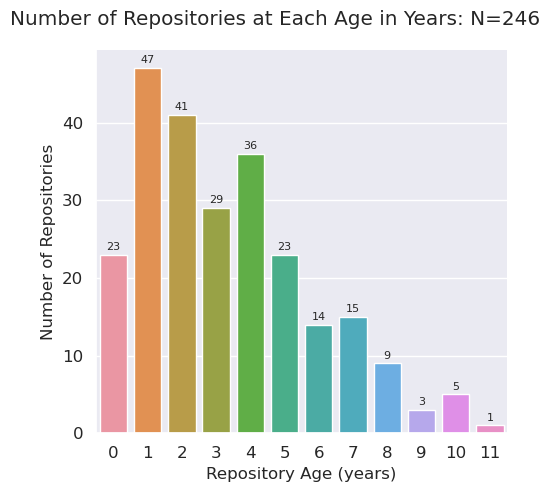

In [154]:
plot = sns.catplot(data=total_stats_200s, x='repo_age_years', kind='count')
plot.figure.subplots_adjust(top=0.9)
plot.fig.suptitle(f"Number of Repositories at Each Age in Years: N={len(total_stats_200s)}")

plt.xticks(size=12)
plt.xlabel('Repository Age (years)', size=12)
plt.yticks(size=12)
plt.ylabel('Number of Repositories', size=12)

# add values to bars (integers)
for i, bar in enumerate(plot.ax.patches):
    h = bar.get_height()
    plot.ax.text(
        i, # bar index (x coordinate of text)
        h+1, # y coordinate of text
        #'{0:.2f}'.format(h),  # y label with 2 decimal places
        '{}'.format(int(h)),  # y label with whole numbers
        ha='center', 
        va='center', 
        #fontweight='bold', 
        size=8)

## Number of Devs Per Repo (mostly under 10, averages ~5)

In [ ]:
# Devs per Repo
# PLOT ALL DEVS
sns.displot(data=total_stats_200s, x='devs')

In [ ]:
# PLOT UNDER 50 DEVS
smaller_teams = total_stats_200s[total_stats_200s['devs'] < 50]
sns.histplot(data=smaller_teams, x='devs', discrete=True)
#len(smaller_teams) # 244
#len(total_stats_200s) #246

In [ ]:
# PLOT UNDER 20 DEVS
smaller_teams = total_stats_200s[total_stats_200s['devs'] <= 20]
sns.histplot(data=smaller_teams, x='devs', discrete=True)

In [ ]:
# PLOT 10 DEVS
smaller_teams = total_stats_200s[total_stats_200s['devs'] <= 10]
sns.histplot(data=smaller_teams, x='devs', discrete=True)

### more devs more tickets!

In [ ]:
sns.scatterplot(data=total_stats_200s, x='devs', y='all_tickets')

In [ ]:
# ZOOM IN ON Devs vs Tickets! 
# PLOT 50 DEVS
smaller_teams = total_stats_200s[total_stats_200s['devs'] <= 50]
sns.scatterplot(data=smaller_teams, x='devs', y='all_tickets')

## Forks don't really make much difference to the data? 

# latest commit activity differs...

In [ ]:
sns.set_theme() 
sns.set_palette('colorblind')

sns.histplot(
    data=total_stats_200s, 
    x='repo_age_days', 
    y='total_commits_last_year',  
    #hue='has_issues', 
    stat='count',
    #binwidth='365',
    discrete=True
)



In [ ]:
sns.set_theme() 
sns.set_palette('colorblind')

g = sns.FacetGrid(total_stats_200s, hue='has_issues', col='repo_is_fork', margin_titles=True, height=6, sharey=True, sharex=False)
#g.add_legend(legend_data={'False':'blue', 'True': 'yellow'})
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("Total Commits in Last Year by Repo Age in Days (size ='N devs')")

### All Repos (including zero commits in last year): commits activity in last year by repo age (UP TO 1000 DAYS)



In [ ]:
sns.set_theme() 
sns.set_palette('colorblind')

first_1k_days = total_stats_200s[total_stats_200s['repo_age_days'] < 1000]

g = sns.FacetGrid(first_1k_days, hue='has_issues', col='repo_is_fork', margin_titles=True, height=6, sharey=True, sharex=False)
#g.add_legend(legend_data={'False':'blue', 'True': 'yellow'})
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("Total Commits in Last Year by Repo Age in Days (FIRST 1000 DAYS ONLY) (size ='N devs')")

## Active Repos: Commits Activity in Last Year by Repo Age

In [ ]:
active_repos = total_stats_200s[total_stats_200s['total_commits_last_year'] >= 1]
len(active_repos) # 77
#print(active_repos)

#first_1k_days = total_stats_200s[total_stats_200s['repo_age_days'] < 1000]

g = sns.FacetGrid(active_repos, hue='has_issues', col='repo_is_fork', margin_titles=True, height=6, sharey=True, sharex=False)
#g.add_legend(legend_data={'False':'blue', 'True': 'yellow'})
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("Total Commits in Last Year by Repo Age in Days AMONGST ACTIVE REPOS ONLY (>1 commit in last year) (size ='N devs')")


In [ ]:
total_stats_200s['issues_enabled'].value_counts() 


In [ ]:
(total_stats_200s['all_tickets'] == 0).sum() # 171 records with 0 issues

In [ ]:
(total_stats_200s['all_tickets'] > 0).sum() # 75 records with 1+ issues

In [ ]:
total_stats_200s['has_PRs'].value_counts()

In [ ]:
total_stats_200s['repo_is_fork'].value_counts()

In [ ]:
total_stats_200s

In [ ]:
total_stats_200s.describe()

In [ ]:
# plot setup  
(sns.set_theme(), 
 sns.set_palette('colorblind'),
 #plt.subplots(figsize=(8,8)),
 sns.relplot(
     data=total_stats_200s, x='repo_age_days', y='devs', alpha=0.5, hue='repo_is_fork'
 ), 
 #plt.xscale('log'),
 #plt.yscale('log') 
)

In [ ]:
len(total_stats_200s[total_stats_200s['total_commits_last_year'] >= 1].index)
# 77 repos with more than 1 commit last year...

### Total commits in last year by repo age; split by using issues

Text(0.5, 0.98, "Total Commits in Last Year by Repo Age in Days (size ='N devs')")

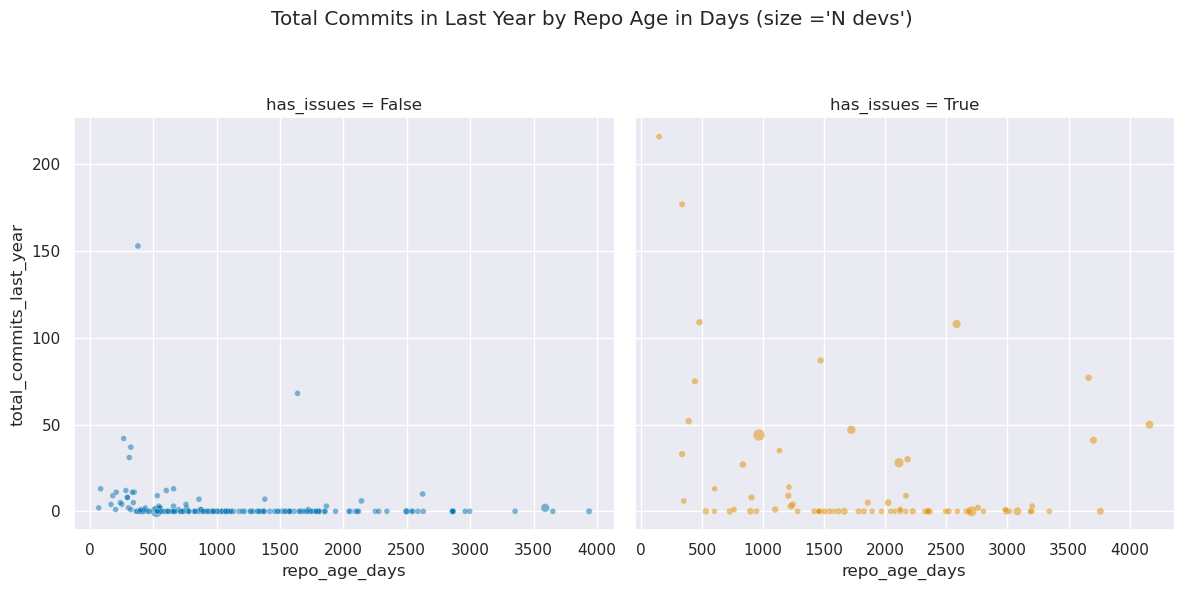

In [143]:
sns.set_theme() 
sns.set_palette('colorblind')

g = sns.FacetGrid(total_stats_200s, hue='has_issues', col='has_issues', margin_titles=True, height=6, sharey=True, sharex=False)
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("Total Commits in Last Year by Repo Age in Days (size ='N devs')")

Text(0.5, 0.98, "Total Commits in Last Year by Repo Age in Days (size ='N devs')")

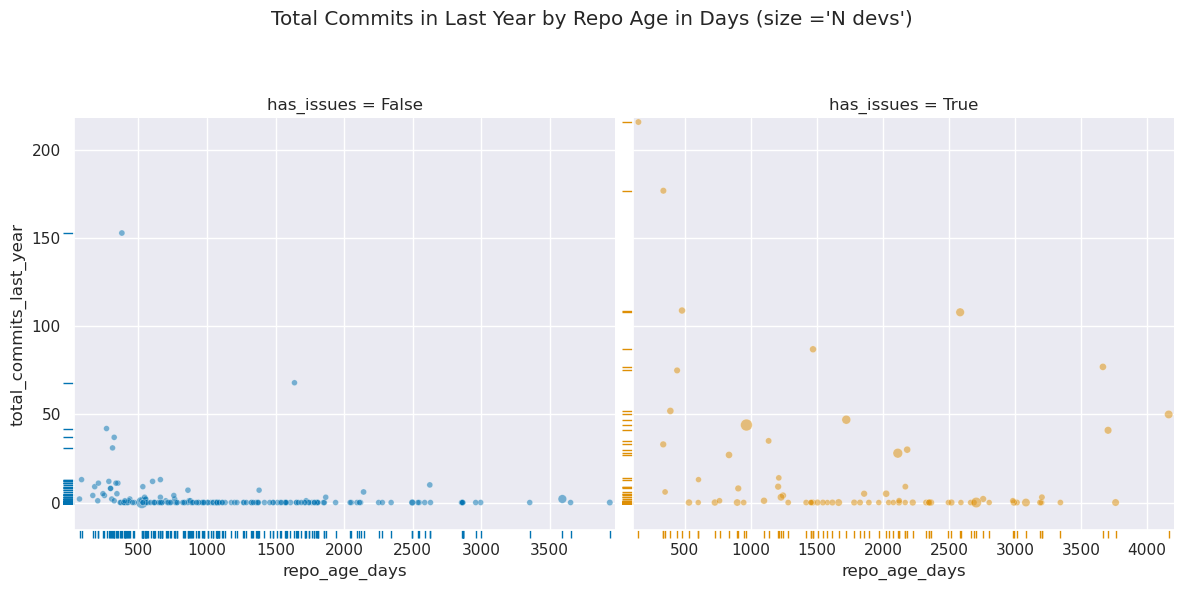

In [144]:
# SAME PLOT BUT WITH 'RUG' TICKS ON AXES
sns.set_theme() 
sns.set_palette('colorblind')

g = sns.FacetGrid(total_stats_200s, hue='has_issues', col='has_issues', margin_titles=True, height=6, sharey=True, sharex=False)
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp = g.map_dataframe(sns.rugplot, x='repo_age_days', y='total_commits_last_year', height=-.02, clip_on=False)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("Total Commits in Last Year by Repo Age in Days (size ='N devs')")

In [ ]:
print(total_stats_200s.dtypes)

In [ ]:
sns.histplot(data=total_stats_200s, x ='closed_tickets', stat='count', discrete=True)

In [ ]:
sns.histplot(data=total_stats_200s, x ='open_tickets', stat='count', discrete=True)


In [ ]:
sns.histplot(data=total_stats_200s, x ='all_tickets')

In [ ]:
# # plot setup  
# (sns.set_theme(), 
#  sns.set_palette('colorblind'),
#  #plt.subplots(figsize=(8,8)),
#  sns.relplot(
#      data=active_repos, x='total_commits_last_year', y='devs', hue='has_PRs', alpha=0.5
#  ), 
#  #plt.xscale('log'),
#  #plt.yscale('log') 
# )

In [ ]:
# # plot setup  
# sns.set_theme() 
# sns.set_palette('colorblind')

# g = sns.FacetGrid(active_repos, hue='has_PRs', col='has_PRs', margin_titles=True, height=6, sharey=True, sharex=False)
# rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
# rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
# #rp.fig.subplot.scale(y='log')
# rp.fig.suptitle("Repos Active within Last Year: Total Commits in Last Year by Repo Age in Days (size ='N devs')")

# total commits last year vs dev count in active repos

In [ ]:
# plot setup  
(sns.set_theme(), 
 sns.set_palette('colorblind'),
 #plt.subplots(figsize=(8,8)),
 sns.relplot(
     data=total_stats_200s, x='total_commits_last_year', y='devs'
 ), 
 #plt.xscale('log'),
 #plt.yscale('log') 
)

# number of devs in active (commit in last year) repos

In [ ]:
bins=[1, 2, 5, 10]


# plot setup  
(sns.set_theme(), 
 sns.set_palette('colorblind'),
 #plt.subplots(figsize=(8,8)),
 sns.displot(
     data=total_stats_200s, x='devs', discrete=True
 ), 
 #plt.xscale('log'),
 #plt.yscale('log') 
)

In [ ]:
ax = sns.countplot(data=total_stats, x='initial_HTTP_code')
ax.set_title(f"HTTP Response Codes for GitHub Repositories; N={len(total_stats.index)}")
ax.bar_label(ax.containers[0])

### get stats for 1 repo  

In [ ]:
#config_path = '../../githubanalysis/config.cfg'

In [ ]:
logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/summarise_repo_stats_NOTEBOOK_logs.txt')  
repo_summariser = RepoStatsSummariser(logger)

In [ ]:
gh_urls_df = pd.read_csv("../../data/todo_2024-02-06.csv", header=0, usecols=['ZenodoID', 'repo_name'], dtype={'ZenodoID':'Int64', 'repo_name':'str'})
gh_urls_df.shape

In [ ]:
gh_urls_df_short = gh_urls_df[30:50]
print(gh_urls_df_short)

In [ ]:
rec_collator = []
loop_num = 0

for repo in gh_urls_df_short.repo_name:
    loop_num += 1
    print(f">>> Getting data for repo {loop_num} of {len(gh_urls_df_short.index)}: {repo}")
    repo_stats = repo_summariser.summarise_repo_stats(repo_name=repo, config_path='../../githubanalysis/config.cfg', per_pg=1, verbose=True)
    rec_collator.append(repo_stats)
    
rec_df = pd.DataFrame(rec_collator)
print(rec_df)

In [ ]:
logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/summarise_repo_stats_NOTEBOOK_B_logs.txt')  
repo_summariser = RepoStatsSummariser(logger)

gh_urls_df_short = gh_urls_df[60:80]
print(gh_urls_df_short)

rec_collator = []
loop_num = 0

for repo in gh_urls_df_short.repo_name:
    loop_num += 1
    print(f">>> Getting data for repo {loop_num} of {len(gh_urls_df_short.index)}: {repo} <<<")
    repo_stats = repo_summariser.summarise_repo_stats(repo_name=repo, config_path='../../githubanalysis/config.cfg', per_pg=1, verbose=True)
    rec_collator.append(repo_stats)
    
rec_df = pd.DataFrame(rec_collator)
print(rec_df)

In [ ]:
logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/summarise_repo_stats_NOTEBOOK_B_logs.txt')  
repo_summariser = RepoStatsSummariser(logger)

gh_urls_df_ton = gh_urls_df[0:100]
#print(gh_urls_df_ton)

rec_collator = []
loop_num = 0

for repo in gh_urls_df_ton.repo_name:
    loop_num += 1
    print(f">>> Getting data for repo {loop_num} of {len(gh_urls_df_short.index)}: {repo} <<<")
    logger.info(f">>> Getting data for repo {loop_num} of {len(gh_urls_df_short.index)}: {repo} <<<")
    repo_stats = repo_summariser.summarise_repo_stats(repo_name=repo, config_path='../../githubanalysis/config.cfg', per_pg=1, verbose=True)
    rec_collator.append(repo_stats)
    
rec_df = pd.DataFrame(rec_collator)
print(rec_df)